# Computer Vision
## Lab 4: Performance Evaluation of Face Tracking in Video Sequences

In [20]:
##########################
# @Authors:              #
#     Belal Hmedan       #
# &   Junyi ZHONG        #
##########################
#
#========================
# Import Libraries
#========================
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
from time import sleep
print("CV Version: ", cv2.__version__)

CV Version:  4.4.0


Get The Background Image for subtraction

In [21]:
# Dataset Path
datasetPath = "/media/desertghost/WD/2_Computer_vision/Datasets/AVDIAR/"
# datasetPath = "F:/Grenoble/Semester_3/2_Computer_vision/Crowley/Datasets/AVDIAR/"

# Get list of all videos
datasetVideos = glob.glob(datasetPath + '/**/**/*.mp4', recursive=True)
for idx, _ in enumerate(datasetVideos):
    datasetVideos[idx] = datasetVideos[idx].replace('\\', '/')
# Sort the list of the videos paths
datasetVideos.sort()

### Load MLP

In [22]:
import tensorflow as tf
# import keras

print(tf.__version__)
# load our best trained model 
model = tf.keras.models.load_model('/media/desertghost/WD/2_Computer_vision/Lecture_2/Lab_2/MLPmodel_Best94.h5')
model.summary()

2.3.1
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
FlattenLayer (Flatten)       (None, 3072)              0         
_________________________________________________________________
HLayer1 (Dense)              (None, 1536)              4720128   
_________________________________________________________________
HLayer2 (Dense)              (None, 1536)              2360832   
_________________________________________________________________
HLayer3 (Dense)              (None, 1536)              2360832   
_________________________________________________________________
OutputLayer (Dense)          (None, 1)                 1537      
Total params: 9,443,329
Trainable params: 9,443,329
Non-trainable params: 0
_________________________________________________________________


### Helper Functions

In [23]:
# Useful Functions 

# Normalization
def normalize(arr, mode="MeanVariance"):
    """
    normalize array
    mode = MinMax , or MeanVariance(Default)
    """
    if mode=="MinMax":
        rng = arr.max()-arr.min()
        amin = arr.min()
        return (arr-amin)*255/rng
    elif mode=="MeanVariance":
        return (arr - arr.mean()) / arr.std()
    else:
        print("Normalization Mode is Wrong")
        return arr

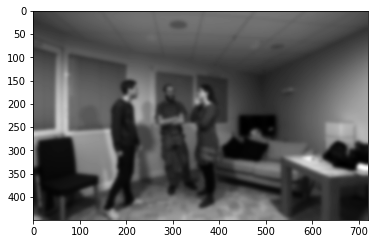

In [24]:
# Read Video Sequence "1", to get the background for subtraction
cap = cv2.VideoCapture(datasetVideos[50])
# Check if video opened successfully
if (cap.isOpened()== False):
  print("Error opening video stream or file")
else:
    _, background = cap.read()
    # Save the first image as reference
    background = cv2.cvtColor(background, cv2.COLOR_BGR2GRAY)
#     background = normalize(background)
#     equBackground = cv2.equalizeHist(background)
    background = cv2.GaussianBlur(background, (21, 21), 0)
    # background = background[...,[2, 1, 0]] # BGR --> RGB
    plt.imshow(background, cmap='gray')
# Release Video capture Object
cap.release()

In [6]:
# Annotations

# nb_frame == int(line[0])
# x0 = int(float(line[2]))
# y0 = int(float(line[3]))
# w = int(float(line[4])) 
# h = int(float(line[5]))

# f = open(os.path.split(datasetVideos[0])[0][:-5] + "GroundTruth/face_bb.txt", "r")
# line = f.readline().split(',') 

Background Subtraction Manual

In [26]:
# Background Subtraction Manual

# Get the Background from first frame
""" Create a VideoCapture object and read from input file
If the input is the camera, pass 0 instead of the video file name"""
cap = cv2.VideoCapture(datasetVideos[50])

nb_frame = 0

# Read until video is completed
while (cap.isOpened()):
    
    # Capture frame-by-frame
    ret, frame = cap.read()
    if ret == True:
        # 
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
#         gray = normalize(gray)
        gray = cv2.GaussianBlur(gray, (7, 7), 0)
        diff = cv2.absdiff(gray, background)
        # Non-Maximum suppression
        lim = 0.50*(np.max(diff)-np.min(diff))
        diff[diff<lim]=0
        diff = cv2.GaussianBlur(diff, (21, 21), 0)
#         frame[diff==0]=0
        idxs = np.nonzero(diff)
        if len(idxs[0])>1:
            x0 = min(idxs[1])
            y0 = int(0.5*min(idxs[0]))
            p0 = tuple([x0, y0])
             
            x1 = max(idxs[1])
            y1 = max(idxs[0])
            p1 = tuple([x1, y1]) 
#             print(p0, p1)

            color = (0, 0, 255)
            if(x1>(x0+1) and int(0.3*y1)>(y0+1)):
                model_input = np.resize(frame[y0:int(0.3*y1), x0:x1,:],(32,32,3))
                model_input = model_input.reshape(1, model_input.shape[0], model_input.shape[1], 3)
                if(model.predict(model_input)):
                    y1 = int(0.3*y1)
                    color = (0, 255, 0)
                else:
                    model_input = np.resize(frame[y0:int(0.6*y1), x0:x1,:],(32,32,3))
                    model_input = model_input.reshape(1, model_input.shape[0], model_input.shape[1], 3)
                    if(model.predict(model_input)):
                        y1 = int(0.6*y1)
                        color = (255, 0, 0)
            # Display the resulting frame
            cv2.rectangle(frame, p0, p1, color, 1)
        
        cv2.imshow("Frame", frame)

        key = cv2.waitKey(1) & 0xFF

        # if the `q` key is pressed, break from the lop
        if key == ord("q"):
            break
    # Break the loop
    else:
        break

# When everything done, release the video capture object
cap.release()
 
# Closes all the frames
cv2.destroyAllWindows()

KeyboardInterrupt: 

Viola Jones

In [28]:
""" Create a VideoCapture object and read from input file
If the input is the camera, pass 0 instead of the video file name"""
cap = cv2.VideoCapture(datasetVideos[50])

nb_frame = 0

# Read until video is completed
while (cap.isOpened()):
    
    # Capture frame-by-frame
    ret, frame = cap.read()
    if ret == True:
        # 
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        gray = cv2.GaussianBlur(gray, (3, 3), 0)
        # Cascade Classifier
        face_cascade = cv2.CascadeClassifier('/media/desertghost/WD/2_Computer_vision/Lecture_5/Lab_4/haarcascade_frontalface_default.xml')
        detected_faces = face_cascade.detectMultiScale(gray.astype(np.uint8), 1.2, 4)
        for (x,y,w,h) in detected_faces:
            center = (x + w//2, y + h//2)
            frame = cv2.ellipse(frame, center, (w//2, h//2), 0, 0, 360, (255, 0, 0), 1)
        cv2.imshow("Viola_Jones", frame)
        key = cv2.waitKey(1) & 0xFF
    # Break the loop
    else:
        break

# When everything done, release the video capture object
cap.release()
 
# Closes all the frames
cv2.destroyAllWindows()

In [27]:
# When everything done, release the video capture object
cap.release()
 
# Closes all the frames
cv2.destroyAllWindows()